In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

In [5]:
# cargamos datos
df = pd.read_csv("datos_integrados.csv", parse_dates=["datetime"])


In [6]:
# separamos por estación
estaciones = df["nombre"].unique()
df_por_estacion = {est: df[df["nombre"] == est].sort_values("datetime").copy() for est in estaciones}

In [7]:
print(estaciones)

['ALGECIRAS EPS' 'JEREZ-CHAPMN' 'SAN FERNANDO']


In [ ]:
#definición de features adicionales y features base
VARS_BASE = ["no2", "temperature_2m", "wind_speed_10m", "relative_humidity_2m"]


def crear_features_balanceado(d: pd.DataFrame, objetivo="o3"):
    # --- temporales ---
    d["year"] = d["datetime"].dt.year
    d["month"] = d["datetime"].dt.month
    d["day"] = d["datetime"].dt.day
    d["hour"] = d["datetime"].dt.hour
    d["dayofweek"] = d["datetime"].dt.dayofweek
    d["weekofyear"] = d["datetime"].dt.isocalendar().week.astype(int)
    d["season"] = ((d["month"] % 12) // 3).astype(int)  # 0..3

    # --- cíclicas ---
    d["hour_sin"] = np.sin(2*np.pi*d["hour"]/24)
    d["hour_cos"] = np.cos(2*np.pi*d["hour"]/24)
    d["dow_sin"]  = np.sin(2*np.pi*d["dayofweek"]/7)
    d["dow_cos"]  = np.cos(2*np.pi*d["dayofweek"]/7)

    # --- rezagos objetivo (sin lag1 y lag2 para no sobreajustar) ---
    for lag in [6, 12, 24, 48, 72]:
        d[f"{objetivo}_lag{lag}"] = d[objetivo].shift(lag)

    # --- rodantes objetivo (ventanas medianas/largas) ---
    for w in [6, 12, 24, 48]:
        d[f"{objetivo}_rollmean_{w}"] = d[objetivo].rolling(w).mean()
        d[f"{objetivo}_rollstd_{w}"] = d[objetivo].rolling(w).std()

    # --- rezagos/rodantes para contaminantes y meteorología ---
    for var in VARS_BASE:
        for lag in [1, 6, 12, 24]:
            d[f"{var}_lag{lag}"] = d[var].shift(lag)
        for w in [6, 12, 24]:
            d[f"{var}_rollmean_{w}"] = d[var].rolling(w).mean()
            d[f"{var}_rollstd_{w}"] = d[var].rolling(w).std()

    # Elimina primeras filas con NaN
    d = d.dropna().reset_index(drop=True)
    return d

# Creamos features en cada estación
for est in estaciones:
    df_por_estacion[est] = crear_features_balanceado(df_por_estacion[est], objetivo="o3")

Modelo base -> RMSE: 4.54, MAE: 3.22
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
RMSE medio CV: 5.115935626647161
Modelo ajustado -> RMSE: 4.44, MAE: 3.16


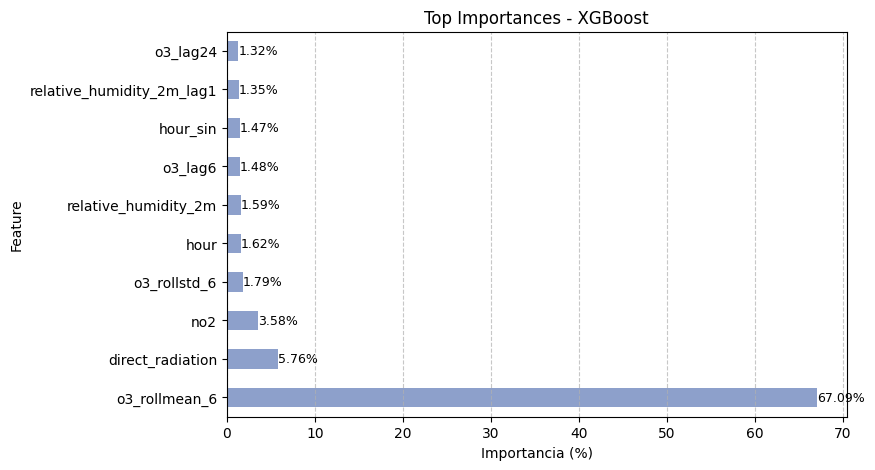

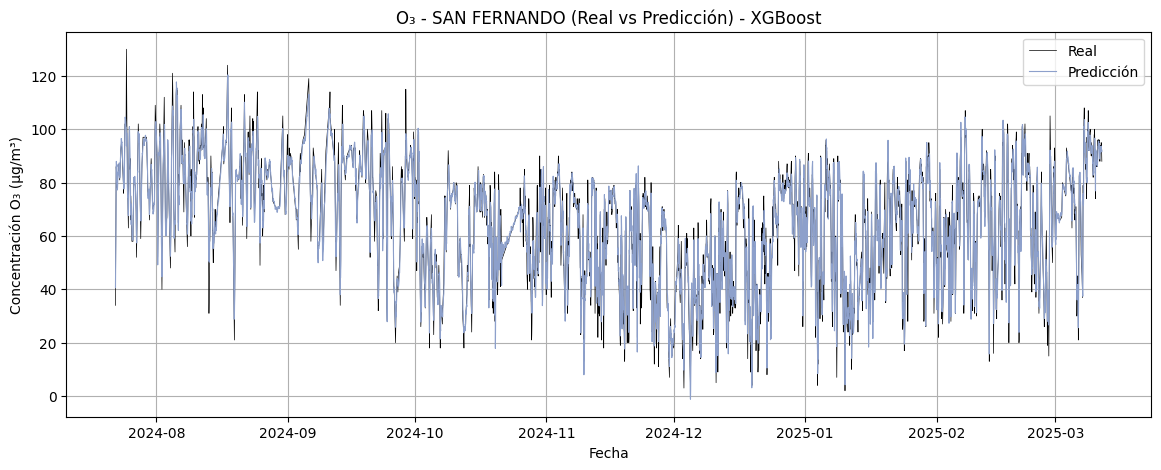

In [ ]:
# ============================
# Configuración
# ============================
estacion = "SAN FERNANDO"
tscv = TimeSeriesSplit(n_splits=5)

# Espacio de búsqueda de hiperparámetros para XGBoost

param_grid = {
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.0, 0.1, 0.3],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 3.0, 5.0],
}

# ============================
# Filtrar datos de la estación
# ============================
d = df_por_estacion[estacion].sort_values("datetime").reset_index(drop=True)

# Variables predictoras y objetivo
drop_cols = ["datetime", "nombre", "estacion", "Latitude", "Longitude", "o3"]
X = d.drop(columns=drop_cols, errors="ignore")
y = d["o3"]

# Optimizar tipos y convertir a numpy
X_np = X.astype(np.float32).to_numpy(copy=False)

# ============================
# Split Train/Test
# ============================
corte = int(len(d) * 0.8)
X_train, X_test = X_np[:corte], X_np[corte:]
y_train, y_test = y.iloc[:corte], y.iloc[corte:]

# ============================
# Modelo base
# ============================
base_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",      #  GPU de Colab
    n_estimators=600,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

print(f"Modelo base -> RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}")

# ============================
# Búsqueda aleatoria con CV temporal (SOLO TRAIN)
# ============================
xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",     # GPU de Colab
    n_estimators=2000,      # alto + ES
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

# Mejor modelo
best_model = search.best_estimator_
print("Mejores parámetros:", search.best_params_)
print("RMSE medio CV:", -search.best_score_)

# ============================
# Evaluación final
# ============================
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Modelo ajustado -> RMSE: {rmse_best:.2f}, MAE: {mae_best:.2f}")

# ============================
# Importancias de variables
# ============================
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_importances_model = importances.sort_values(ascending=False).head(10) * 100

ax = top_importances_model.plot(kind="barh", color="#8da0cb", figsize=(8,5))
for i, valor in enumerate(top_importances_model.values):
    ax.text(valor, i, f"{valor:.2f}%", va='center', ha='left', fontsize=9)

plt.xlabel("Importancia (%)")
plt.ylabel("Feature")
plt.title("Top Importances - XGBoost")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ============================
# Gráfico Real vs Predicción
# ============================
fechas_test = d["datetime"].iloc[corte:]

plt.figure(figsize=(14, 5))
plt.plot(fechas_test, y_test, label="Real", color="black", linewidth=0.5)
plt.plot(fechas_test, y_pred_best, label="Predicción", color="#8da0cb", linewidth=0.8)
plt.title(f"O₃ - {estacion} (Real vs Predicción) - XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Concentración O₃ (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

Modelo base -> RMSE: 5.09, MAE: 3.69
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.001, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
RMSE medio CV: 5.704000817385781
Modelo ajustado -> RMSE: 4.94, MAE: 3.58


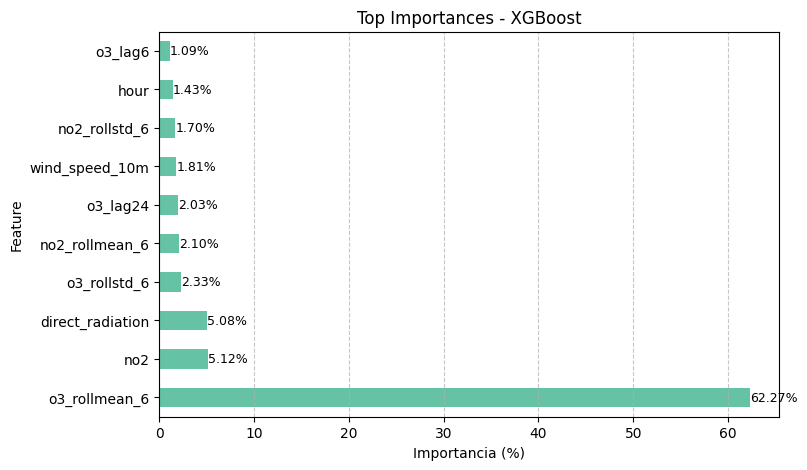

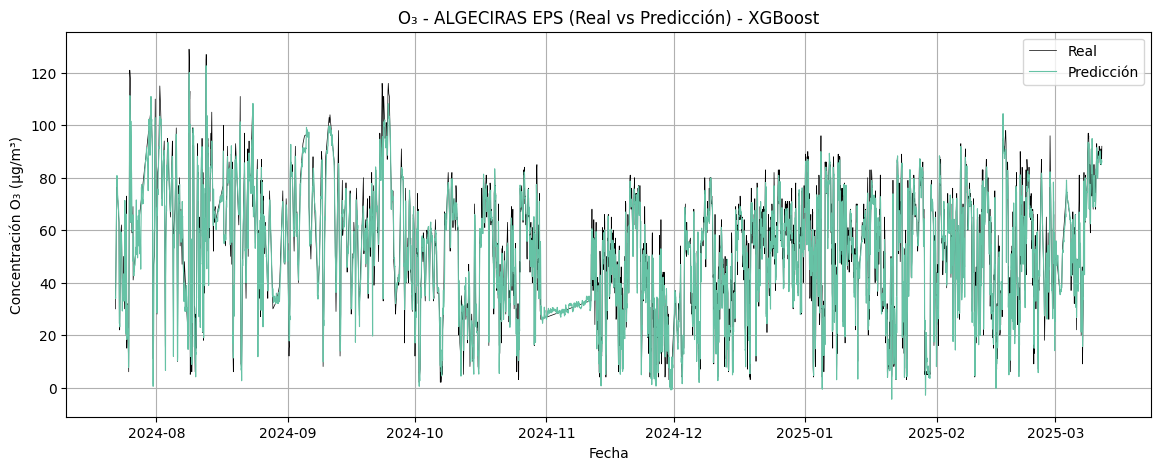

In [ ]:
# ============================
# Configuración
# ============================
estacion = "ALGECIRAS EPS"
tscv = TimeSeriesSplit(n_splits=5)

# Espacio de búsqueda de hiperparámetros para XGBoost

param_grid = {
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.0, 0.1, 0.3],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 3.0, 5.0],
}

# ============================
# Filtrar datos de la estación
# ============================
d = df_por_estacion[estacion].sort_values("datetime").reset_index(drop=True)

# Variables predictoras y objetivo
drop_cols = ["datetime", "nombre", "estacion", "Latitude", "Longitude", "o3"]
X = d.drop(columns=drop_cols, errors="ignore")
y = d["o3"]

# Optimizar tipos y convertir a numpy
X_np = X.astype(np.float32).to_numpy(copy=False)

# ============================
# Split Train/Test
# ============================
corte = int(len(d) * 0.8)
X_train, X_test = X_np[:corte], X_np[corte:]
y_train, y_test = y.iloc[:corte], y.iloc[corte:]

# ============================
# Modelo base
# ============================
base_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",      #  GPU de Colab
    n_estimators=600,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

print(f"Modelo base -> RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}")

# ============================
# Búsqueda aleatoria con CV temporal (SOLO TRAIN)
# ============================
xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",     # GPU de Colab
    n_estimators=2000,      # alto + ES
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

# Mejor modelo
best_model = search.best_estimator_
print("Mejores parámetros:", search.best_params_)
print("RMSE medio CV:", -search.best_score_)

# ============================
# Evaluación final
# ============================
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Modelo ajustado -> RMSE: {rmse_best:.2f}, MAE: {mae_best:.2f}")

# ============================
# Importancias de variables
# ============================
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_importances_model = importances.sort_values(ascending=False).head(10) * 100

ax = top_importances_model.plot(kind="barh", color="#66c2a5", figsize=(8,5))
for i, valor in enumerate(top_importances_model.values):
    ax.text(valor, i, f"{valor:.2f}%", va='center', ha='left', fontsize=9)

plt.xlabel("Importancia (%)")
plt.ylabel("Feature")
plt.title("Top Importances - XGBoost")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ============================
# Gráfico Real vs Predicción
# ============================
fechas_test = d["datetime"].iloc[corte:]

plt.figure(figsize=(14, 5))
plt.plot(fechas_test, y_test, label="Real", color="black", linewidth=0.5)
plt.plot(fechas_test, y_pred_best, label="Predicción", color="#66c2a5", linewidth = 0.8)
plt.title(f"O₃ - {estacion} (Real vs Predicción) - XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Concentración O₃ (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

Modelo base -> RMSE: 6.38, MAE: 4.14
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'subsample': 0.6, 'reg_lambda': 3.0, 'reg_alpha': 0.0, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.8}
RMSE medio CV: 5.903056382677507
Modelo ajustado -> RMSE: 6.32, MAE: 4.12


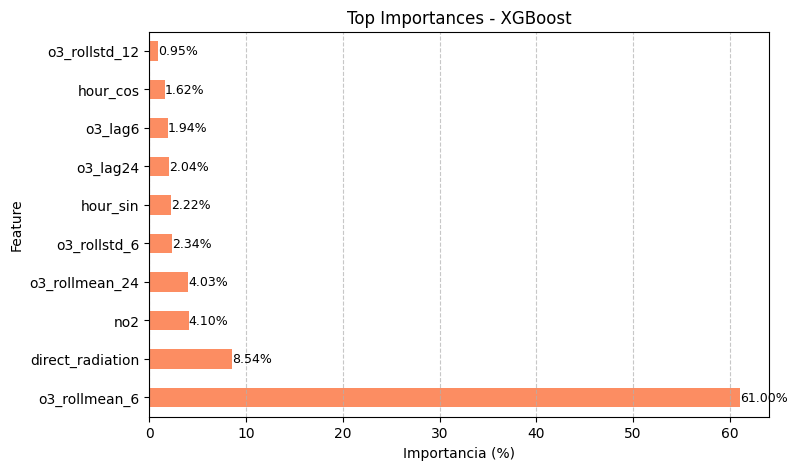

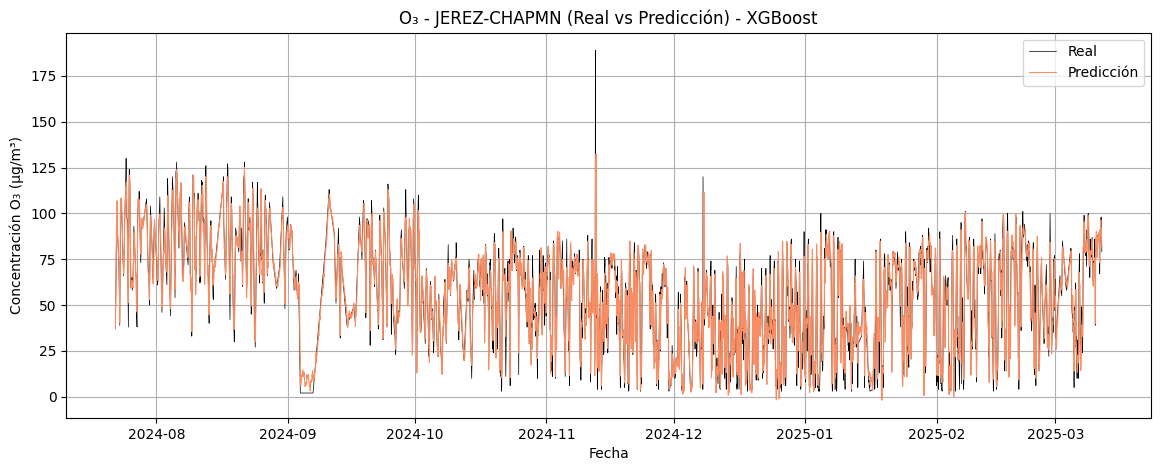

In [ ]:
# ============================
# Configuración
# ============================
estacion = "JEREZ-CHAPMN"
tscv = TimeSeriesSplit(n_splits=5)

# Espacio de búsqueda de hiperparámetros para XGBoost

param_grid = {
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0.0, 0.1, 0.3],
    "reg_alpha": [0.0, 1e-3, 1e-2],
    "reg_lambda": [1.0, 3.0, 5.0],
}

# ============================
# Filtrar datos de la estación
# ============================
d = df_por_estacion[estacion].sort_values("datetime").reset_index(drop=True)

# Variables predictoras y objetivo
drop_cols = ["datetime", "nombre", "estacion", "Latitude", "Longitude", "o3"]
X = d.drop(columns=drop_cols, errors="ignore")
y = d["o3"]

# Optimizar tipos y convertir a numpy
X_np = X.astype(np.float32).to_numpy(copy=False)

# ============================
# Split Train/Test
# ============================
corte = int(len(d) * 0.8)
X_train, X_test = X_np[:corte], X_np[corte:]
y_train, y_test = y.iloc[:corte], y.iloc[corte:]

# ============================
# Modelo base
# ============================
base_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",      #  GPU de Colab
    n_estimators=600,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
mae_base = mean_absolute_error(y_test, y_pred_base)

print(f"Modelo base -> RMSE: {rmse_base:.2f}, MAE: {mae_base:.2f}")

# ============================
# Búsqueda aleatoria con CV temporal (SOLO TRAIN)
# ============================
xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="gpu_hist",     # GPU de Colab
    n_estimators=2000,      # alto + ES
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

# Mejor modelo
best_model = search.best_estimator_
print("Mejores parámetros:", search.best_params_)
print("RMSE medio CV:", -search.best_score_)

# ============================
# Evaluación final
# ============================
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Modelo ajustado -> RMSE: {rmse_best:.2f}, MAE: {mae_best:.2f}")

# ============================
# Importancias de variables
# ============================
importances = pd.Series(best_model.feature_importances_, index=X.columns)
top_importances_model = importances.sort_values(ascending=False).head(10) * 100

ax = top_importances_model.plot(kind="barh", color="#fc8d62", figsize=(8,5))
for i, valor in enumerate(top_importances_model.values):
    ax.text(valor, i, f"{valor:.2f}%", va='center', ha='left', fontsize=9)

plt.xlabel("Importancia (%)")
plt.ylabel("Feature")
plt.title("Top Importances - XGBoost")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# ============================
# Gráfico Real vs Predicción
# ============================
fechas_test = d["datetime"].iloc[corte:]

plt.figure(figsize=(14, 5))
plt.plot(fechas_test, y_test, label="Real", color="black", linewidth=0.5)
plt.plot(fechas_test, y_pred_best, label="Predicción", color="#fc8d62",linewidth = 0.8)
plt.title(f"O₃ - {estacion} (Real vs Predicción) - XGBoost")
plt.xlabel("Fecha")
plt.ylabel("Concentración O₃ (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()